In [152]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tq
from tqdm import trange
import pickle
plt.rcParams.update({'font.size': 8})

In [134]:
class NeuronModelConfig:
    """
    Configuration class that defines the neuron model as a collection of other functions
    """
    def __init__(self, params, input_potential, rate_dendrite_integral, initial_rate_soma, 
                 rate_soma, refractory_kernel, dendritic_kernel):
        
        self.params = params
        self.input_potential = input_potential
        self.rate_dendrite_integral = rate_dendrite_integral
        self.initial_rate_soma = initial_rate_soma
        self.rate_soma = rate_soma
        self.refractory_kernel = refractory_kernel
        self.dendritic_kernel = dendritic_kernel

        
def default_params():
    """
    Generate a dictionary with the default neuron model parameters.

    Return
    ------
        params (dict): Parameters defining the neuron model.

    """
    params = {}
    
    # input potential parameters
    params['L'] = 10
    params['I_d'] = 1
    params['I_s'] = 1
    params['x_d'] = 8
    
    # dendritic rate parameters
    params['lambda_d'] = .1
    params['B'] = 1
    params['v_B'] = 2
    
    # somatic rate parameters
    params['lambda_s'] = .01
    params['R'] = 1
    params['delta_R'] = 1
    params['D'] = 2
    params['delta_D'] = 2
    
    params['tau'] = 10*1e-3 # hypothetical membrane time constant for scaling time.

    # gaussian mask parameters
    params['mu'] = 8
    params['sigma'] = 0.5
    
    # gaussian input parameters
    params['xd_I'] = 8
    params['sigma_I'] = 0.5
    
    params['tau_syn'] = 0.3
    
    return params


def input_potential_uniform(X, config):
    """
    Estimate the input potnential at locations X for a neuron with parameters given by params. Localized somatic and dendritic input.

    Args
    ----
        X (Ndarray): 1xN array of spatial locations along the dendrite.
        params (dict): Dicionary of parameter values defining the neuron model.

    Return
    ------
        Array of input potentials corresponing to the locations given by the input X.
    """
    params = config.params
    
    I_s = params['I_s']
    I_d = params['I_d']
    x_d = params['x_d']
    L = params['L']
    
    N = 100 # approximation of infinite sum
    n = np.arange(-N, N+1) # n = {-N, -(N-1), ..., 0, ..., (N-1), N}
    
    if type(X)==int:  # if only a point estimate is needed at location X
        dx = 0.00001
        h = np.sum((I_s/2)*(np.exp(-1*np.abs(X-2*n*L+dx))+np.exp(-1*np.abs(X-2*n*L-dx))) + (I_d/2)*(np.exp(-1*np.abs(X-2*n*L-x_d)) + np.exp(-1*np.abs(X-2*n*L+x_d))))
    else: # get estimate of the input potential for each entry of X
        h = np.zeros(len(X))
        dx = X[1]-X[0]
        for i, x in enumerate(X): 
            h[i] = np.sum((I_s/2)*(np.exp(-1*np.abs(x-2*n*L+dx)) + np.exp(-1*np.abs(x-2*n*L-dx))) + (I_d/2)*(np.exp(-1*np.abs(x-2*n*L-x_d)) + np.exp(-1*np.abs(x-2*n*L+x_d))))
        
    return h

def relu(x):
    y=x
    y[x<0] = 0
    
    return y

def refractory_kernel_square(t, config):
    
    params = config.params
    
    R = params['R']
    delta_R = params['delta_R']
    
    ref = -R*np.heaviside(delta_R - t, 1)
    
    return ref

def dendritic_kernel_square(t, config):
    params = config.params
    
    D = params['D']
    delta_D = params['delta_D']
    
    d_spike = D*np.heaviside(delta_D - t, 1)
    
    return d_spike


def rate_dendrite_integral(t, t_hat, h, dx, config):
    """
    Integral of the dendritic hazard rate over space. Non-spatial case.

    Args
    ----
        t (TYPE): DESCRIPTION.
        t_hat (TYPE): DESCRIPTION.
        params (TYPE): DESCRIPTION.

    Return
    ------
        continuous_part (TYPE): DESCRIPTION.
        continuous_part_vec (TYPE): DESCRIPTION.
        discrete_part (TYPE): DESCRIPTION.

    """
    params = config.params
    
    lambda_d = params['lambda_d']
    L = params['L']
    v_B = params['v_B']
    B = params['B']    
    
    continuous_part  = lambda_d*np.sum(h)*dx
    discrete_part = lambda_d*B*np.heaviside(L/v_B - (t-t_hat), 1)
    continuous_part_vec = lambda_d*h
    
    return continuous_part, continuous_part_vec, discrete_part


def initial_rate_soma(t, t_hat, h_0, config):
    """
    Calculate the initial somatic hazard rate.

    Args
    ----
        t (float): Current time.
        t_hat (float): Time of the last somatic spike.
        h_0 (float): Input potential evaluated at x=0.
        params (dict): Parameters defining the neuron model.

    Return
    ------
        rate (float): initial somatic hazard rate evaluated at time t given t_hat

    """
    
    params = config.params
    refractory_kernel = config.refractory_kernel
    
    lambda_s = params['lambda_s']
    ref = refractory_kernel(t=(t-t_hat), config=config)
    rate = lambda_s*np.exp(h_0 + ref) 
    
    return rate

def rate_soma(t, t_p, t_hat, h_0, config):
    """
    Calculate the soamtic hazard rate (after a dendritic spike has ocurred).

    Args
    ----
        t (float): Current time.
        t_p (float): Time of the last dendritic spike.
        t_hat (float): Time of the last somatic spike.
        params (dict): Parameters defining the neuron model.

    Return

        rate (TYPE): Somatic hazard rate evaluated at time t given t_hat and t_p.

    """
    params = config.params
    refractory_kernel = config.refractory_kernel
    dendritic_kernel = config.dendritic_kernel
    
    lambda_s = params['lambda_s']
    ref = refractory_kernel(t=(t-t_hat), config=config)
    d_spike = dendritic_kernel(t=(t-t_p), config=config)
    rate = lambda_s*np.exp(h_0 + ref + d_spike)
    
    return rate

def survivor_dendrite(t_vec, dt, dx, h, config):
    """
    Calculate the dendritic survivor function

    Args
    ----
        t_vec (numpy array): A vector representing t-t_hat
        dt (float): Integration timestep
        rate_dendrite (function): Dendriic hazard rate
        params (dict): Parameters defining the neuron model.

    Return
    ------
        survivor_function (numpy array): Dendritic survivor function

    """
    rate_dendrite_integral = config.rate_dendrite_integral
    
    t_hat = 0 # we can assume this to be zero without loss of generality
    
    rates = np.zeros(len(t_vec))
    for i, t in enumerate(t_vec): 
        continuous_part, continuous_part_vec, discrete_part = rate_dendrite_integral(t=t, t_hat=t_hat, h=h, dx=dx, config=config)
        rates[i] = continuous_part + discrete_part
        
    survivor_function = np.exp(-np.cumsum(rates)*dt)
        
    return survivor_function


def survivor_initial_soma(t_vec, dt, h_0, config):
    """
    Calculate the initial somatic survivor function.
    
    Args
    ----
    t_vec (numpy array): A vector representing t-t_hat
    dt (float): Integration timestep
    rate_dendrite (function): Dendriic hazard rate
    params (dict): Parameters defining the neuron model.

    Return
    ------
        survivor_function (numpy array): Initial somatic survivor function

    """    
    initial_rate_soma = config.initial_rate_soma
    
    t_hat = 0 # we can assume this to be zero without loss of generality
    
    rates = np.zeros(len(t_vec))
    for i, t in enumerate(t_vec): 
        rates[i] = initial_rate_soma(t=t, t_hat=t_hat, h_0=h_0, config=config)
        
    survivor_function = np.exp(-np.cumsum(rates)*dt)
    
    return survivor_function

# NOTE: The above two functions are essentially the same 
# and can be possible combined into one function with a different hazard rates


def survivor_conditional_soma(t_vec, dt, h_0, config):
    """
    Calculate the conditional somatic survivor function (dependent on the last somatic and dendritic spike times).
    
    Args
    ----
    t_vec (numpy array): A vector representing t-t_p
    dt (float): Integration timestep
    rate_dendrite (function): Dendriic hazard rate
    params (dict): Parameters defining the neuron model.

    Return
    ------
        survivor_function (numpy array): Initial somatic survivor function

    """    
    rate_soma = config.rate_soma
    
    t_p_matrix, t_matrix = np.meshgrid(t_vec, t_vec)
    t_hat = 0 # we can assume this to be zero without loss of generality 
    
    rate_matrix = rate_soma(t=t_matrix, t_p=t_p_matrix, t_hat=t_hat, h_0=h_0, config=config)
    
    rate_matrix_lower = np.tril(rate_matrix)
    survivor_function = np.exp(-np.cumsum(rate_matrix_lower, axis=0)*dt)

    return survivor_function, rate_matrix_lower

In [135]:
def isi_density_one_dendritic_spike(t_max, config):
    """
    Numerically integrate the marginal survivor function.

    Args
    ----
        t_max (TYPE): DESCRIPTION.
        params (TYPE): DESCRIPTION.
        epsilon (TYPE): DESCRIPTION.
        dendritic_rate (func): Integral of the dendritic hazard rate over space. Can we for the spatial or non-spatial case. 
        survivor_d (func): Survivor function of the dendrite. Can be for the spatial or non-spatial case.

    Return
    ------
        S_theory TYPE: Marginal somatic survivor probability as a function of time
        t_prime_vec TYPE: The times corresponding to each value in S_theory

    """
    
    params = config.params
    input_potential = config.input_potential
    rate_dendrite_integral = config.rate_dendrite_integral
    initial_rate_soma = config.initial_rate_soma
    
    t_hat = 0
    dtp = t_max/10000
    epsilon = 1e-7
    
    L = params['L']
    v_B = params['v_B']
    dx = v_B*dtp
    x_grid = np.linspace(0, L, int(L/dx)+1)
    h = input_potential(X=x_grid, config=config) 
    
    t_prime_vec = np.linspace(0, t_max, int(t_max/dtp)+1)
    
    S_d = survivor_dendrite(t_vec=t_prime_vec, dt=dtp, dx=dx, h=h, config=config)
    
    continuous_part, _, discrete_part  = rate_dendrite_integral(t=t_prime_vec, t_hat=t_hat, h=h, dx=dx, config=config)
    rate_d = continuous_part + discrete_part
    
    S_s0 = survivor_initial_soma(t_vec=t_prime_vec, dt=dtp, h_0=h[0], config=config)
    
    S_s, rate_matrix_lower = survivor_conditional_soma(t_vec=t_prime_vec, dt=dtp, h_0=h[0], config=config)
    
    r_0 = initial_rate_soma(t=t_prime_vec, t_hat=0, h_0=h[0], config=config)
    
    S_mat = S_s*rate_matrix_lower
    S_tmp = survivor_dendrite(t_vec=t_prime_vec, dt=dtp, dx=dx, h=h, config=config)*survivor_initial_soma(t_vec=t_prime_vec, dt=dtp, h_0=h[0], config=config)
    S_theory = S_s0*S_d*r_0
    
    for i, t in enumerate(t_prime_vec):    
        S_theory[i] += np.sum(S_tmp[:i]*rate_d[:i]*S_mat[i, :i])*dtp
        
    return S_theory, t_prime_vec

def integrate_survivor_one_dendritic_spike(t_max, config):
    """
    Numerically integrate the marginal survivor function.

    Args
    ----
        t_max (TYPE): DESCRIPTION.
        params (TYPE): DESCRIPTION.
        epsilon (TYPE): DESCRIPTION.
        dendritic_rate (func): Integral of the dendritic hazard rate over space. Can we for the spatial or non-spatial case. 
        survivor_d (func): Survivor function of the dendrite. Can be for the spatial or non-spatial case.

    Return
    ------
        S_theory TYPE: Marginal somatic survivor probability as a function of time
        t_prime_vec TYPE: The times corresponding to each value in S_theory

    """
    
    params = config.params
    input_potential = config.input_potential
    rate_dendrite_integral = config.rate_dendrite_integral
    
    t_hat = 0
    dtp = t_max/10000
    epsilon = 1e-7
    
    L = params['L']
    v_B = params['v_B']
    dx = v_B*dtp
    x_grid = np.linspace(0, L, int(L/dx)+1)
    h = input_potential(X=x_grid, config=config) 
    
    t_prime_vec = np.linspace(0, t_max, int(t_max/dtp)+1)
    
    S_d = survivor_dendrite(t_vec=t_prime_vec, dt=dtp, dx=dx, h=h, config=config)
    
    continuous_part, _, discrete_part  = rate_dendrite_integral(t=t_prime_vec, t_hat=t_hat, h=h, dx=dx, config=config)
    rate_d = continuous_part + discrete_part
    
    S_s0 = survivor_initial_soma(t_vec=t_prime_vec, dt=dtp, h_0=h[0], config=config)
    
    S_s, _ = survivor_conditional_soma(t_vec=t_prime_vec, dt=dtp, h_0=h[0], config=config)
    
    S_tmp = survivor_dendrite(t_vec=t_prime_vec, dt=dtp, dx=dx, h=h, config=config)*survivor_initial_soma(t_vec=t_prime_vec, dt=dtp, h_0=h[0], config=config)
    S_theory = S_s0*S_d

    for i, t in enumerate(t_prime_vec): 
        S_theory[i] += np.sum(S_tmp[:i]*rate_d[:i]*S_s[i, :i])*dtp
        
    return S_theory, t_prime_vec


In [136]:
def monte_carlo_one_dendritic_spike(nb_steps, nb_neurons, dt, config, sample_dendritic_spike_locations=False):
    """
    Monte Carlo sample the two-compartment renewal model.
    
    Args
    ----
        nb_steps (TYPE): DESCRIPTION.
        dt (TYPE): DESCRIPTION.
        params (TYPE): DESCRIPTION.
        dendritic_rate (TYPE): DESCRIPTION.

    Return
    ------
        intervals (list): Somatic interspike intervals. 
        somatic_spike_train (Ndarray): Array of spikes (0's and 1's)
        dendritic_spike_train (Ndarray): Array of spikes (0's and 1's)

    """
    
    input_potential = config.input_potential
    rate_dendrite_integral = config.rate_dendrite_integral
    initial_rate_soma = config.initial_rate_soma
    rate_soma = config.rate_soma
    params = config.params
    
    

    # define grid of plocations along the dendrite
    L = params['L']
    v_B = params['v_B']
    dx = v_B*dt
    x_grid = np.linspace(0, L, int(L/dx)+1)
    
    # evaluate the input potential along the dendrite
    h = input_potential(X=x_grid, config=config) 
    
    somatic_intervals = []
    last_s_spike = np.zeros(nb_neurons) 
    last_d_spike = np.zeros(nb_neurons)
    last_d_spike_location = np.zeros(nb_neurons)
    
    somatic_spike_train = np.zeros((nb_neurons, nb_steps))
    dendritic_spike_train = np.zeros((nb_neurons, nb_steps))
    dendritic_spike_locations = np.zeros((nb_neurons, nb_steps))

    dendrite_alive = np.asarray([True]*nb_neurons)
    
    for i in range(nb_steps):
        
        continuous_part, continuous_part_vec, discrete_part = rate_dendrite_integral(t=i*dt, t_hat=last_s_spike*dt, h=h, dx=dx, config=config)
        prob_d = 1 - np.exp(-(continuous_part+discrete_part)*dt)
        
        rand_d = np.random.rand(nb_neurons)
        d_spike_boolean = (rand_d<=prob_d)
        
        d_spike_update = np.logical_and(d_spike_boolean, dendrite_alive)
        last_d_spike[d_spike_update] = i
        dendrite_alive[d_spike_update] = False
        
         # sample dendritic spike locations
        if sample_dendritic_spike_locations==True:
            
            r1 = np.random.rand(nb_neurons)
            
            # check if dendritic spike occurs at BAP location
            BAP_location_boolean = (r1<=(discrete_part/(continuous_part+discrete_part)))
            
            updated_BAP_location = np.logical_and(BAP_location_boolean, d_spike_update)
            
            last_d_spike_location[updated_BAP_location] = v_B*(i-last_s_spike[updated_BAP_location])*dt
            
            dendritic_spike_locations[updated_BAP_location, i] = v_B*(i-last_s_spike[updated_BAP_location])*dt
            
            # get locations that are left to sample
            continuous_location_boolean = np.logical_and(np.logical_not(BAP_location_boolean), d_spike_update)
            
            while np.sum(continuous_location_boolean)>0: 
                x_rand = np.random.randint(low=0, high=len(x_grid), size=nb_neurons)
                r2 = np.random.rand(nb_neurons)
    
                continuous_spiked_boolean = (r2 <= continuous_part_vec[x_rand]/(continuous_part+discrete_part))
                
                updated_continuous_location = np.logical_and(continuous_spiked_boolean, continuous_location_boolean)
                last_d_spike_location[updated_continuous_location] = x_grid[x_rand[updated_continuous_location]]
                dendritic_spike_locations[updated_continuous_location, i] = x_grid[x_rand[updated_continuous_location]]
                
                continuous_location_boolean = np.logical_and(continuous_location_boolean, np.logical_not(continuous_spiked_boolean))
                
                
        # 1xnb_neurons size array of rates    
        initial_rate_soma_tmp = initial_rate_soma(t=i*dt, t_hat=last_s_spike*dt, h_0=h[0], config=config)
        rate_soma_tmp = rate_soma(t=i*dt, t_p=last_d_spike*dt, t_hat=last_s_spike*dt, h_0=h[0], config=config)
        
        prob_s = 1 - np.exp(-rate_soma_tmp*dt)
        prob_s[dendrite_alive] = 1 - np.exp(-initial_rate_soma_tmp[dendrite_alive]*dt)
    
        rand_s = np.random.rand(nb_neurons)
       
        s_spike_boolean = (rand_s<=prob_s)
        
        reset_dendrite = np.logical_and(s_spike_boolean, np.logical_not(dendrite_alive))
        dendrite_alive[reset_dendrite]=True
        
        somatic_spike_train[s_spike_boolean,i] = 1
        last_s_spike[s_spike_boolean] = i       
        


    return somatic_spike_train, dendritic_spike_train, dendritic_spike_locations

In [137]:
def calcualte_statistics_monte_carlo(spike_train, dt, config): 
    
    params = config.params
    intervals = []
    tau=params['tau']
    
    nb_neurons, nb_steps = np.shape(spike_train)
    As = np.zeros(nb_neurons)
    cvs = np.zeros(nb_neurons)
    
    t = np.arange(nb_steps)*dt
    
    #spike_train = spike_train[:, :int(nb_steps/2)] #only use last half
    #t = t[:int(nb_steps/2)]
    
    for n in range(nb_neurons):
        
        spike_times = t[spike_train[n,:]==1]
        intervals_tmp = np.diff(spike_times)
        
        if n==0:
            intervals = intervals_tmp
        else: 
            np.hstack((intervals, intervals_tmp))
        
        mu = np.mean(intervals_tmp)
        sigma = np.std(intervals_tmp)
        
        As[n] = 1/(mu*tau)
        cvs[n] = sigma/mu
    
    return intervals, As, cvs

# ISI density with/without the BAP

In [138]:
params_passive = default_params()
params_passive['D']=0
params_passive['I_s'] = 2.5
params_passive['I_d'] = 5
params_passive['B'] = 10

passive_config = NeuronModelConfig(params=params_passive, input_potential=input_potential_uniform, rate_dendrite_integral=rate_dendrite_integral, 
                             initial_rate_soma=initial_rate_soma, rate_soma=rate_soma, 
                                refractory_kernel=refractory_kernel_square, dendritic_kernel=dendritic_kernel_square)

params_active = default_params()
params_active['D']=2
params_active['I_s'] = 2.5
params_active['I_d'] = 5
params_active['B'] = 10


active_config = NeuronModelConfig(params=params_active, input_potential=input_potential_uniform, rate_dendrite_integral=rate_dendrite_integral, 
                             initial_rate_soma=initial_rate_soma, rate_soma=rate_soma, 
                                refractory_kernel=refractory_kernel_square, dendritic_kernel=dendritic_kernel_square)

params_BAP = default_params()
params_BAP['D']=2
params_BAP['I_s'] = 2.5
params_BAP['I_d'] = 5
params_BAP['B'] = 0


BAP_config = NeuronModelConfig(params=params_BAP, input_potential=input_potential_uniform, rate_dendrite_integral=rate_dendrite_integral, 
                             initial_rate_soma=initial_rate_soma, rate_soma=rate_soma, 
                                refractory_kernel=refractory_kernel_square, dendritic_kernel=dendritic_kernel_square)


In [139]:
t_max = 500

pdf_passive, t_vec = isi_density_one_dendritic_spike(t_max=t_max, config=passive_config)
pdf_active, t_vec = isi_density_one_dendritic_spike(t_max=t_max, config=active_config)
pdf_BAP, t_vec = isi_density_one_dendritic_spike(t_max=t_max, config=BAP_config)

In [140]:
dt = 0.01
nb_steps = 10000000
nb_neurons = 1

passive_spike_train, _, _ = monte_carlo_one_dendritic_spike(nb_steps=nb_steps, nb_neurons=nb_neurons, dt=dt, config=passive_config)
active_spike_train, _, _ = monte_carlo_one_dendritic_spike(nb_steps=nb_steps, nb_neurons=nb_neurons, dt=dt, config=active_config)
BAP_spike_train, _, _ = monte_carlo_one_dendritic_spike(nb_steps=nb_steps, nb_neurons=nb_neurons, dt=dt, config=BAP_config)

In [141]:
passive_intervals, _, _ = calcualte_statistics_monte_carlo(spike_train=passive_spike_train, dt=dt, config=passive_config)
active_intervals, _, _ = calcualte_statistics_monte_carlo(spike_train=active_spike_train, dt=dt, config=active_config)
BAP_intervals, _, _ = calcualte_statistics_monte_carlo(spike_train=BAP_spike_train, dt=dt, config=BAP_config)

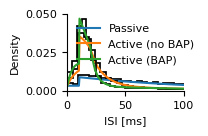

In [142]:
params = default_params()
tau  = params['tau']
plt.figure(figsize=(1.5,1))

#passive_intervals = np.asarray(passive_intervals)
plt.hist(passive_intervals*tau*1e3, 200, density=True, color='k', histtype='step', fill=False, linewidth=1.25)
plt.plot(t_vec*tau*1e3, pdf_passive/(tau*1e3), linestyle='-', label='Passive',)

#BAP_intervals = np.asarray(BAP_intervals)
plt.hist(BAP_intervals*tau*1e3, 200, density=True, histtype='step', fill=False, color='k', linewidth=1.25)
plt.plot(t_vec*tau*1e3, pdf_BAP/(tau*1e3), label='Active (no BAP)', linestyle='-')

#active_intervals=np.asarray(active_intervals)
plt.hist(active_intervals*tau*1e3, 200, density=True, color='k', histtype='step', fill=False, linewidth=1.25)
plt.ylabel('Density')
plt.xlabel('ISI [ms]')

plt.plot(t_vec*tau*1e3, pdf_active/(tau*1e3),linestyle='-', label='Active (BAP)')
#plt.title('Active Dendrite')
plt.xlim([0, 100])
plt.xticks([0, 50, 100])

plt.legend(frameon=False)
plt.yticks([0, 0.025, 0.05])

sns.despine()
#plt.tight_layout()

plt.savefig('../results/Figure_BAP_Density_V1.svg')

# Dendritic survivor function

The BAP should just act like a third input current when $z>\frac{2}{\bar{\lambda}_{d}(I_{s}+I_{d}+B)}$. Real speeds to reach the end will be on the order of a few ms, implying that $z<1$, as our units are scaled by $\tau=10ms$. 

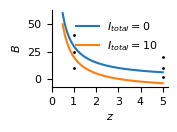

In [143]:
B1 = [10, 25, 40]
B2 = [2, 10, 20]

plt.figure(figsize=(1.5, 1))

z_vec = np.linspace(0.5, 5, 100)

I_total_vec = [0, 10]

for I_total in I_total_vec:
    
    B_vec = 3/(z_vec*0.1) - I_total
    
    plt.plot(z_vec, B_vec, label='$I_{total}=$'+f'{I_total}')
    
for B in B1: 
    plt.plot(1, B, '.', color='k', ms=2)
    
for B in B2: 
    plt.plot(5, B, '.', color='k', ms=2)
    
plt.ylabel('$B$')
plt.xlabel('$z$')
plt.legend(frameon=False)
plt.yticks([0, 25, 50])
plt.xticks([0, 1, 2, 3, 4, 5])
sns.despine()

plt.savefig('../results/Figure_BAP_inequality.svg')

# f-I and CV-I plots with changing values of the BAP

In [144]:
def estimate_t_max(epsilon, config):
    
    initial_rate_soma = config.initial_rate_soma
    input_potential = config.input_potential
    dt = 0.01
    rate_integral = 0
    n=0
    
    h_0 = input_potential(X=0, config=config) 
    
    while rate_integral<np.log(1/epsilon):
        rate_integral += initial_rate_soma(t=n*dt, t_hat=0, h_0=h_0, config=config)*dt
        n += 1
        
    t_max = n*dt
    
    return t_max

def ensemble_response_theory(I_s_vec, I_d_vec, integrate_survivor, config):
    """
    Calucluate the stationary firing rate and cv using the integration method.

    Args
    ----
        I_s_vec (TYPE): DESCRIPTION.
        I_d_vec (TYPE): DESCRIPTION.
        params (TYPE): DESCRIPTION.
        dendritic_rate (TYPE): DESCRIPTION.
        survivor_dendrite (TYPE): DESCRIPTION.

    Return
    ------
        A_inf_mat (TYPE): DESCRIPTION.

    """
    params = config.params
    epsilon = 0.01
    tau = params['tau']
    
    A = np.zeros((len(I_d_vec), len(I_s_vec)))
    cv = np.zeros((len(I_d_vec), len(I_s_vec)))
    
    i=0
    for I_s in tq.tqdm(I_s_vec, desc="I_s Loop", position=0):
        
        params['I_s'] = I_s
        
        j=0
        for I_d in tq.tqdm(I_d_vec, desc="I_d Loop", position=1, leave=False):
            
            params['I_d'] = I_d
            
            t_max = estimate_t_max(epsilon=epsilon, config=config)
            
            S_theory, t_vec_theory = integrate_survivor(t_max=t_max, config=config)
            dt = t_vec_theory[1]
            
            A[j, i] = (1/(np.sum(S_theory)*dt*tau))    
            
            T_first_moment = (np.sum(S_theory)*dt)
            T_second_moment = 2*np.sum(S_theory*t_vec_theory)*dt
            cv[j, i] = np.sqrt((T_second_moment - T_first_moment**2) / T_first_moment**2)
            
            j+=1
        i+=1

    return A, cv


def ensemble_repsonse_BAP(I_s_vec, B_vec, z, integrate_survivor, config):
    
    params = config.params
    epsilon = 0.001
    tau = params['tau']
    params['I_d'] = 0
    params['v_B'] = params['L']/z
    
    A = np.zeros((len(B_vec), len(I_s_vec)))
    cv = np.zeros((len(B_vec), len(I_s_vec)))
    
    i=0
    for I_s in tq.tqdm(I_s_vec, desc="I_s Loop", position=0):
        
        params['I_s'] = I_s
        
        j=0
        for B in tq.tqdm(B_vec, desc="B Loop", position=1, leave=False):
            
            params['B'] = B
            
            t_max = estimate_t_max(epsilon=epsilon, config=config)
            
            S_theory, t_vec_theory = integrate_survivor(t_max=t_max, config=config)
            dt = t_vec_theory[1]
            
            A[j, i] = (1/(np.sum(S_theory)*dt*tau))    
            
            T_first_moment = (np.sum(S_theory)*dt)
            T_second_moment = 2*np.sum(S_theory*t_vec_theory)*dt
            cv[j, i] = np.sqrt((T_second_moment - T_first_moment**2) / T_first_moment**2)
            
            j+=1
        i+=1
    
    return A, cv


In [145]:
I_d_vec = np.linspace(0, 5, 3) # currents to run analysis over
I_s_vec = np.linspace(0, 5, 31)

I_d_vec1 = [10, 25, 40]
I_d_vec2 = [2, 10, 20]


A_theory_all = []
cv_theory_all = []
params = default_params()
params['B'] = 0


uniform_config = NeuronModelConfig(params=params, input_potential=input_potential_uniform, rate_dendrite_integral=rate_dendrite_integral, 
                             initial_rate_soma=initial_rate_soma, rate_soma=rate_soma, 
                                refractory_kernel=refractory_kernel_square, dendritic_kernel=dendritic_kernel_square)

A_theory1, cv_theory1 = ensemble_response_theory(I_s_vec=I_s_vec, I_d_vec=I_d_vec1, 
                                               integrate_survivor=integrate_survivor_one_dendritic_spike, 
                                               config=uniform_config)

A_theory2, cv_theory2 = ensemble_response_theory(I_s_vec=I_s_vec, I_d_vec=I_d_vec2, 
                                               integrate_survivor=integrate_survivor_one_dendritic_spike, 
                                               config=uniform_config)

I_s Loop:   0%|          | 0/31 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_s Loop:   0%|          | 0/31 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

In [146]:
def plot_ensemble_response_theory(A, A_passive, cv, cv_passive, I_s_vec, I_d_vec):
    
    plt.figure(figsize=(6,2))

    plt.subplot(1,2,1)
    for i, I_d in enumerate(I_d_vec):
        plt.plot(I_s_vec, A[i, :], label='$I_{d}$='+f'{I_d}')
    
        #plt.plot(I_s_vec, A_passive[i,:], linestyle='--', color='k')

    plt.xlabel('$I_{s}$')
    plt.ylabel('$A_{\infty}$ [Hz]')
    sns.despine()
    plt.legend(frameon=False)
    
    #plt.yscale('log')

    plt.subplot(1,2,2)
    for i, I_d in enumerate(I_d_vec):
        plt.plot(I_s_vec, cv[i, :], label='$I_{d}$='+f'{I_d}')
        #plt.plot(I_s_vec, cv_passive[i,:], linestyle='--', color='k')
        
    plt.ylim([0.5, 1.5])
    plt.yticks([0.5, 1, 1.5])

    plt.xlabel('$I_{s}$')
    plt.ylabel('$C_{v}$')
    sns.despine()
    
    plt.tight_layout()
    
    return

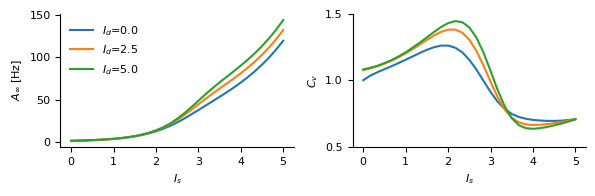

In [147]:
plot_ensemble_response_theory(A=A_theory, cv=cv_theory, A_passive=A_theory_passive, cv_passive=cv_theory_passive, 
                              I_s_vec=I_s_vec, I_d_vec=I_d_vec)

In [148]:
z1 = 1
z2 = 5
B1 = [10, 25, 40]
B2 = [2, 10, 20]
I_s_vec = np.linspace(0, 5, 31)

params = default_params()

uniform_config = NeuronModelConfig(params=params, input_potential=input_potential_uniform, rate_dendrite_integral=rate_dendrite_integral, 
                             initial_rate_soma=initial_rate_soma, rate_soma=rate_soma, 
                                refractory_kernel=refractory_kernel_square, dendritic_kernel=dendritic_kernel_square)

A_B1, cv_B1 = ensemble_repsonse_BAP(I_s_vec=I_s_vec, B_vec=B1, z=z1, 
                                            integrate_survivor=integrate_survivor_one_dendritic_spike,
                                            config=uniform_config)

A_B2, cv_B2 = ensemble_repsonse_BAP(I_s_vec=I_s_vec, B_vec=B2, z=z2, 
                                            integrate_survivor=integrate_survivor_one_dendritic_spike,
                                            config=uniform_config)


I_s Loop:   0%|          | 0/31 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_s Loop:   0%|          | 0/31 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

B Loop:   0%|          | 0/3 [00:00<?, ?it/s]

In [149]:
def plot_ensemble_response_BAP(A, cv, A2, cv2, I_s_vec, I_d_vec, B_vec, filename):
    
    plt.figure(figsize=(2, 3))
    alphas = [1, 0.7, 0.5]
    plt.subplot(2,1,1)
    for i, B in enumerate(B_vec):
        plt.plot(I_s_vec, A[i, :], color='tab:blue', alpha=alphas[i], label='$B$='+f'{B}')
        plt.plot(I_s_vec, A2[i, :], linestyle='--', color='tab:red', alpha=alphas[i], label='$I_{d}$='+f'{I_d_vec[i]}')
    

    plt.xlabel('$I_{s}$')
    plt.ylabel('Frequency [Hz]')
    sns.despine()
    plt.legend(frameon=False)
    plt.xticks([0, 2.5, 5])
    
    #plt.yscale('log')

    plt.subplot(2,1,2)
    for i, B in enumerate(B_vec):
        plt.plot(I_s_vec, cv[i, :], color='tab:blue', alpha=alphas[i], label='$B$='+f'{B}')
        plt.plot(I_s_vec, cv2[i, :], linestyle='--', color='tab:red', alpha=alphas[i], label='$I_{d}$='+f'{I_d_vec[i]}')
        
    plt.ylim([0.5, 2])
    plt.yticks([0.5, 1, 1.5])
    plt.xticks([0, 2.5, 5])

    plt.xlabel('$I_{s}$')
    plt.ylabel('$C_{v}$')
    sns.despine()
    
    plt.tight_layout()
    plt.savefig(filename)
    
    return

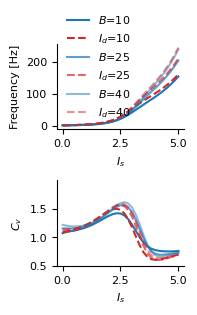

In [150]:
plot_ensemble_response_BAP(A=A_B1, cv=cv_B1, A2=A_theory1, cv2=cv_theory1, I_s_vec=I_s_vec, I_d_vec=I_d_vec1, B_vec=B1, filename='../results/z1.svg')

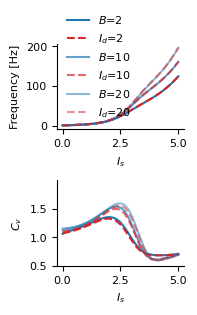

In [151]:
plot_ensemble_response_BAP(A=A_B2, cv=cv_B2, A2=A_theory2, cv2=cv_theory2, I_s_vec=I_s_vec, I_d_vec=I_d_vec2, B_vec=B2, filename='../results/s2.svg')